In [2]:
# Data manipulation
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

## Features

In [3]:
import glob
# Get a list of all CSV file paths in the "Data" folder
csv_files = glob.glob('Data/BRA_ABR_2019_02/*.csv')

# Open each CSV file and store the data in a list
df_list = []
for file in csv_files:
    df = pd.read_csv(file)
    df_list.append(df)

### Describe

In [4]:
# # Nb of points for each dataset
# # for df in df_list:
# #     if len(df["lon"]) < 100:
# #         print(len(df))

# sorted_df_list = sorted(df_list, key=lambda x: len(x))
# sorted_df_list = [len(df["lon"]) for df in sorted_df_list]
# plt.title("Nb de points pour chaque dataset")
# plt.plot(sorted_df_list)



In [5]:
# features = df_list[0]
# features = pd.read_csv('Data/BRA_ABR_2019_02/DACTYLATRA MACHO U46399  DEZ 2019 AXYTREK RT2.csv')
# features.head(5)
# features = pd.read_csv('Data/DACTYLATRA MACHO U46399  DEZ 2019 AXYTREK RT2 modif.csv')
# # Pour DACTYLATRA MACHO U46399  DEZ 2019 AXYTREK RT2 
# # (changer la valeur de lon, lat, dist_to_nest pour ligne 3014 (on interpole précédente-suivante))
# # print(features[features["dist_to_nest"] > 300])
# pd.set_option('display.max_columns', None)
# total_columns = len(df.columns)
# print(features.iloc[3010:3020, total_columns - 15:])

# # features.drop(features[features["dist_to_nest"] > 300].index, inplace=True)



In [6]:
# features.describe()

In [7]:
# features.columns

In [8]:
# print(features["dist_to_nest"])

## Lat-Lon-Height

Trajectoires restructurées


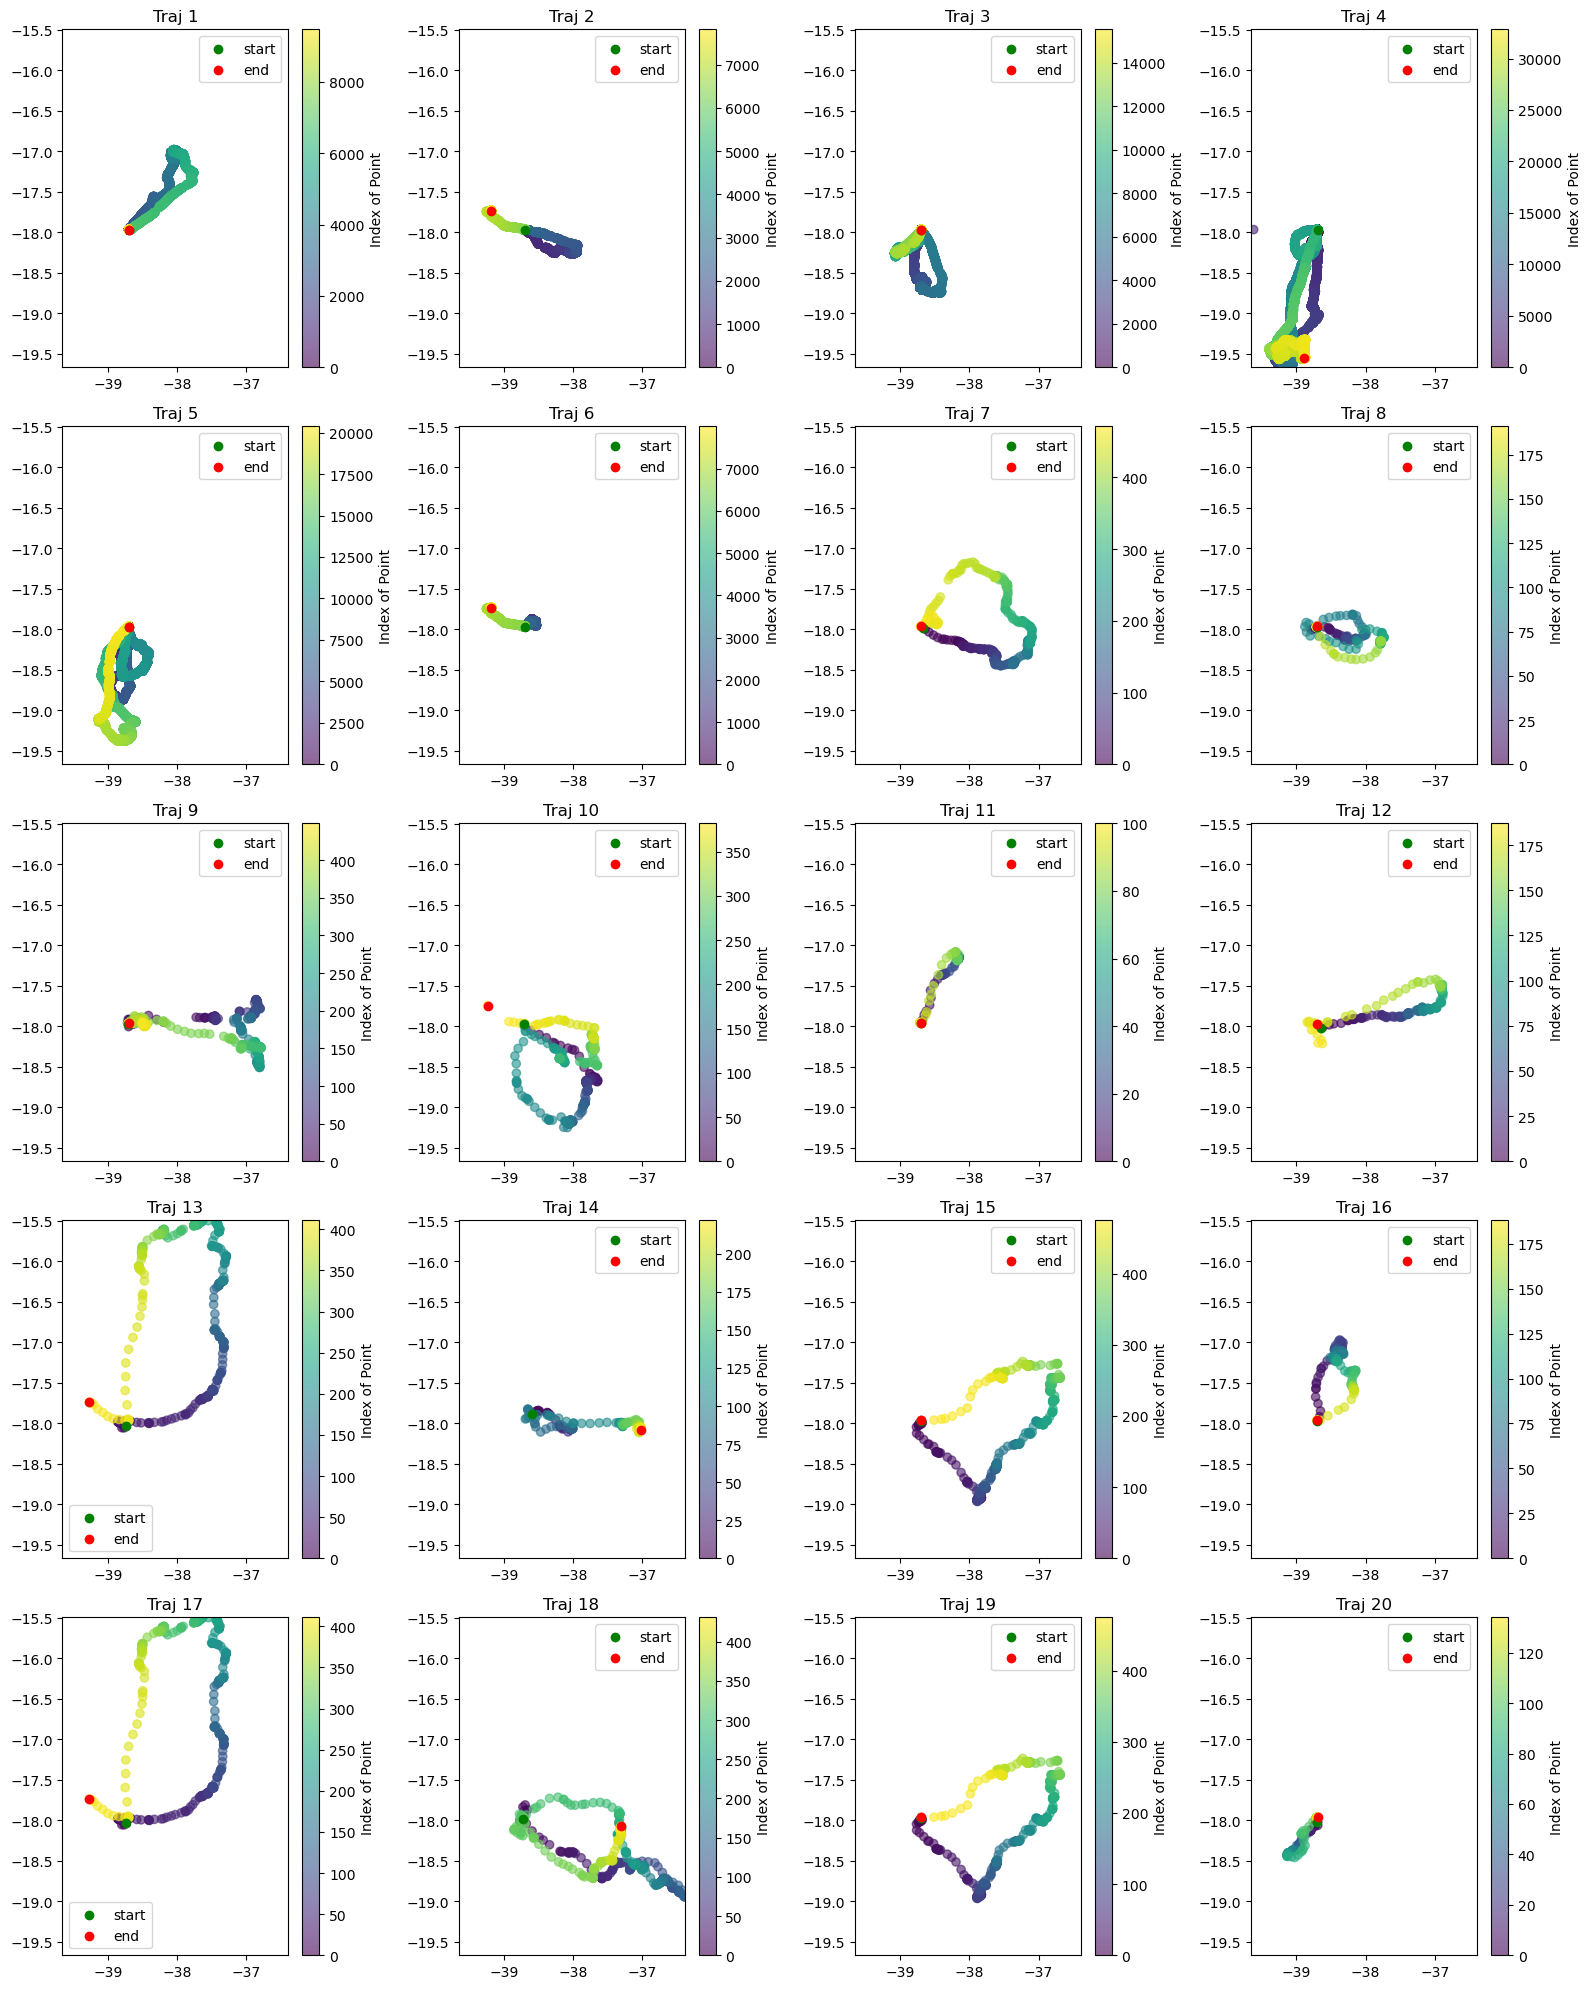

In [12]:
# nb = len(df_list)
nb = 20
num_cols = 4
num_rows = int(np.ceil(nb / num_cols))

# Calculate the size of each subplot
subplot_size = 4
fig_width = num_cols * subplot_size
fig_height = num_rows * subplot_size

lon_arrays = [df['lon'].values for df in df_list]
lon_concatenated = np.concatenate(lon_arrays)
x_min = np.min(lon_concatenated)
x_max = np.max(lon_concatenated)

lat_arrays = [df['lat'].values for df in df_list]
lat_concatenated = np.concatenate(lat_arrays)
y_min = np.min(lat_concatenated)
y_max = np.max(lat_concatenated)

# Create a figure with subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(fig_width, fig_height))


# Plot each trajectory
for i, ax in enumerate(axs.flatten()):
    if i < nb:
        indices = np.arange(len(df_list[i]['lon']))
        norm = plt.Normalize(indices.min(), indices.max())
        cmap = plt.get_cmap('viridis')
        colors = cmap(norm(indices))

        x = df_list[i]['lon']
        y = df_list[i]['lat']

        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)

        scatter = ax.scatter(x, y, c=indices, cmap='viridis', marker='o', alpha=0.6)
        
        # Add start and end points
        ax.scatter(x[0], y[0], color='green', label='start')
        ax.scatter(x.iloc[-1], y.iloc[-1], color='red', label='end')

        ax.set_title(f'Traj {i+1}')
        ax.legend(loc='best')
        
        # Add colorbar to each subplot
        plt.colorbar(scatter, ax=ax, label='Index of Point')
    else:
        ax.axis('off')  # Hide empty subplots

print("Trajectoires restructurées")
plt.tight_layout()
plt.show()

# Folium

In [14]:
import folium
import random
from folium.plugins import TimeSliderChoropleth
import json
import plotly.express as px
import plotly.graph_objects as go

In [15]:
def random_color():
    r =lambda: random.randint(0,255)
    return('#%02X%02X%02X' % (r(),r(),r()))

def plot_map(df_data, colony, save = False, path = "") :
    m = folium.Map(location = colony, zoom_start=8)

    folium.Marker(colony, popup="<i>Colony</i>").add_to(m)
    i = 1
    for df in df_data:
        t = f"Trajectory {i}"
        locations = list(zip(df['lat'], df['lon']))
        
        folium.PolyLine(tooltip = t,
                    locations = locations,
                    color = random_color(),
                    weight=2,
                    opacity=1).add_to(m)
        i += 1
        
    display(m) 
    
    if save : 
        m.save(path)       
    return

In [16]:
def plot_map_time(df_list, colony):
    fig = go.Figure()

    for i, df in enumerate(df_list):
        df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'], format='%d/%m/%Y %H:%M:%S.%f')
        df.sort_values('datetime', inplace=True)
        df['text'] = df['datetime'].dt.strftime('%d/%m/%Y %H:%M:%S.%f')

        fig.add_trace(go.Scattermapbox(
            lat=df['lat'],
            lon=df['lon'],
            mode='lines',
            line=dict(color=random_color(), width=2),
            name=f'Trajectory {i+1}',
            text=df['text'],
            hoverinfo='text',
            visible=False
        ))

    # Set the first trace visible
    fig.data[0].visible = True

    # Define steps for the slider
    sliders = []
    for t in combined_df['datetime'].unique():
        steps = [{"visible": [False] * len(fig.data)} for _ in range(len(df_list))]
        for j, df in enumerate(df_list):
            df_subset = df[df['datetime'] <= t]
            if not df_subset.empty:
                steps[j]["visible"] = [True] * len(steps[j]["visible"])  # Set all to True up to this step
        slider = dict(
            active=0,
            steps=[dict(method="update", args=[{"visible": step}], label=str(t)) for step, t in zip(steps, combined_df['datetime'].unique())],
            x=0.1,
            len=0.9
        )
        sliders.append(slider)

    fig.update_layout(
        sliders=sliders,
        mapbox=dict(
            style="carto-positron",
            center=dict(lat=colony['lat'], lon=colony['lon']),
            zoom=10
        ),
        margin={"r": 0, "t": 0, "l": 0, "b": 0}
    )

    fig.show()


In [17]:
# data_path = 'Data/BRA_ABR_2019_02/'
# BRA_ABR_2019_02  BRA_ABR_2020_02  BRA_ABR_2021_05  BRA_ABR_2022_08  BRA_ABR_2023_09  
Date = 'BRA_ABR_2022_08'
data_path = "Data_segmented/"+Date+"/by_dist/"  # Path to the folder where the segmented data will be stored

### All datasets locations

In [18]:
def plot_colonies(colonies, save = False, path = "") :
    m = folium.Map(location = colonies[0], zoom_start=8)
    for colony in colonies:
        folium.Marker(colony, popup="<i>Colony</i>").add_to(m)
    display(m)      
    return

In [19]:
colony_abr= [-17.97, -38.70]
colony_fdn = [-3.86, -32.43]
# -3.858406, -32.433314
# colonies = [colony_abr, colony_fdn]
colonies = [colony_abr]
plot_colonies(colonies)

### Phaeton

In [20]:
# csv_files_phaet = glob.glob(data_path +'P*.csv')
csv_files_phaet = glob.glob(data_path +'Phaet/*.csv')

# Open each CSV file and store the data in a list
df_list_phaet = []
for file in csv_files_phaet:
    df = pd.read_csv(file)
    df_list_phaet.append(df)

print(df_list_phaet[0][["lat","lon"]].iloc[0])
colony_phaet = df_list_phaet[0][["lat","lon"]].iloc[0]

# plot_map(df_list_phaet, colony_phaet)

lat   -17.98988
lon   -38.63605
Name: 0, dtype: float64


In [21]:
# Assuming the first point of the first trajectory is the colony location
colony_phaet = df_list_phaet[0][["lat","lon"]].iloc[0]

plot_map(df_list_phaet, colony_phaet)


c:\Users\julie\anaconda3\envs\myenv_python\Lib\site-packages\folium\utilities.py:86: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coords = (location[0], location[1])


### Sula

In [22]:
# csv_files_sula = glob.glob(data_path +'SU*.csv')
csv_files_sula = glob.glob(data_path +'Sula/*.csv')

# Open each CSV file and store the data in a list
df_list_sula = []
for file in csv_files_sula:
    df = pd.read_csv(file)
    df_list_sula.append(df)

if len(df_list_sula) > 0:
    print(df_list_sula[0][["lat","lon"]].iloc[0])
    colony_sula = df_list_sula[0][["lat","lon"]].iloc[0]

    plot_map(df_list_sula, colony_sula)

### Dactyl

In [23]:
# file_pattern_dactyl = os.path.join(data_path, "D*.csv")
# csv_files_d = glob.glob(file_pattern_dactyl)

# file_pattern_sdactyl = os.path.join(data_path, "SD*.csv")
# csv_files_sd = glob.glob(file_pattern_sdactyl)

# csv_files_dactyl = csv_files_d + csv_files_sd

csv_files_dactyl = glob.glob(data_path +'Dactyl/*.csv')


# Open each CSV file and store the data in a list
df_list_dactyl = []
for file in csv_files_dactyl:
    df = pd.read_csv(file)
    df_list_dactyl.append(df)

if len(df_list_dactyl) > 0:
    print(df_list_dactyl[0][["lat","lon"]].iloc[0])
    colony_dactyl = df_list_dactyl[0][["lat","lon"]].iloc[0]

    plot_map(df_list_dactyl, colony_dactyl)

lat   -17.96423
lon   -38.69263
Name: 0, dtype: float64


c:\Users\julie\anaconda3\envs\myenv_python\Lib\site-packages\folium\utilities.py:86: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coords = (location[0], location[1])


# Gantt

In [24]:
def plot_gantt_1(df_list):
    # Create a new dataframe for Gantt chart
    gantt_df = pd.DataFrame(columns=['Task', 'Start', 'Finish', 'Resource'])
    
    for i, df in enumerate(df_list):

        df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'], format='%d/%m/%Y %H:%M:%S.%f')

        start_time = df['datetime'].min()
        end_time = df['datetime'].max()
        gantt_df = pd.concat([gantt_df, pd.DataFrame({
            'Task': f'Trajectory {i+1}',
            'Start': [start_time],
            'Finish': [end_time],
            'Resource': [f'Trajectory {i+1}']
        })], ignore_index=True)
    
    fig = px.timeline(gantt_df, x_start="Start", x_end="Finish", y="Task", color="Resource")
    fig.update_yaxes(categoryorder="total ascending")
    
    # Adding slider
    fig.update_layout(
        xaxis=dict(
            rangeselector=dict(
                buttons=list([
                    dict(count=1, label="1d", step="day", stepmode="backward"),
                    dict(count=7, label="1w", step="day", stepmode="backward"),
                    dict(count=1, label="1m", step="month", stepmode="backward"),
                    dict(step="all")
                ])
            ),
            rangeslider=dict(visible=True),
            type="date"
        )
    )

    fig.show()

In [25]:
def plot_gantt(df_list):
    gantt_df = pd.DataFrame(columns=['Task', 'Start', 'Finish', 'Resource'])

    for i, df in enumerate(df_list):
        # Vérification et ajustement du format des colonnes date et time
        try:
            df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'], format='%d-%m-%Y %H:%M:%S.%f')
        except ValueError:
            try:
                df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'], format='%d/%m/%Y %H:%M:%S.%f')
            except ValueError:
                raise ValueError("Unknown date format in the dataset.")

        df.sort_values('datetime', inplace=True)
        df['text'] = df['datetime'].dt.strftime('%d/%m/%Y %H:%M:%S.%f')

        start_time = df['datetime'].min()
        end_time = df['datetime'].max()

        gantt_df = pd.concat([gantt_df, pd.DataFrame({
            'Task': [f'Trajectory {i+1}'],
            'Start': [start_time],
            'Finish': [end_time],
            'Resource': [f'Trajectory {i+1}']
        })])

    fig = px.timeline(gantt_df, x_start='Start', x_end='Finish', y='Task', color='Resource')
    fig.update_layout(
        title='Trajectories Gantt Chart',
        xaxis_title='Time',
        yaxis_title='Trajectory'
    )
    fig.show()

### Phaeton

In [26]:
plot_gantt(df_list_phaet)

C:\Users\julie\AppData\Local\Temp\ipykernel_29520\2798322160.py:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  gantt_df = pd.concat([gantt_df, pd.DataFrame({


### Sula

In [27]:
plot_gantt(df_list_sula)

### Dactyl

In [28]:
plot_gantt(df_list_dactyl)

C:\Users\julie\AppData\Local\Temp\ipykernel_29520\2798322160.py:20: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



# EOF (Empirical Orthogonal Functions)

In [1]:
# from scipy.linalg import eigh
# from eofs.standard import Eof

# num_nodes = 50
# oiseau = "Dactyl/"
# csv_files = glob.glob("Data_segmented_with_dist_reshaped/*/"+str(num_nodes)+"nodes/"+oiseau+"*.csv")

# # Initialize a list to store the data
# data_list = []

# # Loop over each file
# for f in csv_files:
#     # Read the CSV file
#     data = pd.read_csv(f).values
#     data_list.append(data)

# # Concatenate the data into a single array
# data = np.concatenate(data_list, axis=0)

# # Create an Eof object
# solver = Eof(data)

# # Calculate the EOFs
# eofs = solver.eofsAsCovariance()

# # Calculate the principal components (PCs)
# pcs = solver.pcs()

# # Calculate the variance explained by each EOF
# variance_explained = solver.varianceFraction()

# # Plot the leading EOFs
# plt.figure(figsize=(8, 6))
# for i in range(5):  # plot the first 5 EOFs
#     plt.plot(eofs[:, i])
#     plt.title(f'EOF {i+1} ({variance_explained[i]*100:.2f}%)')
#     plt.xlabel('Trajectory Index')
#     plt.ylabel('Amplitude')
# plt.tight_layout()
# plt.show()